In [1]:
import numpy as np
import matplotlib.pyplot as plt

class PDWorld_env:
    def __init__(self, alpha, num_agents, gamma, epsilon):
        self.grid_size = 5
        self.num_agents = num_agents
        self.num_pickups = 3
        self.num_dropoffs = 3
        self.state_size = self.grid_size ** 2
        self.action_size = 6 # Up, Down, Left, Right, Pickup, Dropoff
        self.q_tables = [{} for _ in range(self.num_agents)]  # Q-table for each agent
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        
        # ADDED VIZ THINGS
        # self.reward_grid = np.zeros((self.grid_size, self.grid_size))
        self.action_count = np.zeros((self.grid_size, self.grid_size, self.action_size))
        self.agent_grids = [np.zeros((self.grid_size, self.grid_size)), np.zeros((self.grid_size, self.grid_size)), np.zeros((self.grid_size, self.grid_size))]

    def get_q_tables(self):
        return self.q_tables
    
    def get_agents(self):
        return self.agents
    
    # STATES include: all agent positions, each agent's carrying status, remaining boxes on each pickup point
    def get_state(self):
        # Return the current state of the environment as a string
        agent_positions = '.'.join([f'{x}{y}' for x, y in self.agents])
        agent_carry_flags = '.'+'.'.join(['1' if carrying else '0' for carrying in self.carries_block])
        dropoff_remaining_flags = '.'
        for (x, y) in self.pickups:
            dropoff_remaining_flags += str(self.blocks_on_ground[(x,y)])
        
        return agent_positions + agent_carry_flags + dropoff_remaining_flags
    
    def reset(self):
        self.agents = [(2, 0), (2, 2), (2, 4)]  # Initial positions of agents
        self.pickups = [(4, 0), (3, 1), (1, 4)]  # Pickup spots
        self.dropoffs = [(0, 0), (0, 2), (4, 3)]  # Dropoff spots
        self.carries_block = [False] * self.num_agents
        self.blocks_on_ground = {(x, y): 4 if (x, y) in self.pickups else 0 for x in range(self.grid_size) for y in range(self.grid_size)}
        return self.get_state()
    
    def change_pickup_spots(self):
        self.pickups = [(4, 2), (3, 3), (2, 4)]  # Pickup spots
        self.blocks_on_ground = {(x, y): 4 if (x, y) in self.pickups else 0 for x in range(self.grid_size) for y in range(self.grid_size)}

    def prandom(self):
        actions = [0, 0, 0]
        for i in range(3):
            x, y = self.agents[i]
            if (x, y) in self.pickups and self.blocks_on_ground[(x,y)] > 0 and (not self.carries_block[i]):
                    actions[i] = 4
            elif (x, y) in self.dropoffs and self.carries_block[i] and self.blocks_on_ground[(x,y)] < 4:
                actions[i] = 5
            else:
                actions[i] = np.random.randint(0, self.action_size - 2)
        return self.step(actions)
    
    def pgreedy(self):
        actions = [0, 0, 0]
        for i in range(3):
            x, y = self.agents[i]
            if (x, y) in self.pickups and self.blocks_on_ground[(x,y)] > 0 and (not self.carries_block[i]):
                    actions[i] = 4
            elif (x, y) in self.dropoffs and self.carries_block[i] and self.blocks_on_ground[(x,y)] < 4:
                actions[i] = 5
            else:
                key = self.get_state()
                
                q_values = self.get_q_values(i, key)[:4]
                
                best_actions = np.where(q_values == np.max(q_values))[0]
                # Break any tie
                actions[i] = np.random.choice(best_actions)
        return self.step(actions)
    
    def pxploit(self):
        actions = [0, 0, 0]
        #set seed for reproducability
        decide = np.random.default_rng()
        for i in range(3):
            x, y = self.agents[i]
            if (x, y) in self.pickups and self.blocks_on_ground[(x,y)] > 0 and (not self.carries_block[i]):
                actions[i] = 4
            elif (x, y) in self.dropoffs and self.carries_block[i] and self.blocks_on_ground[(x,y)] < 4:
                actions[i] = 5
            else:
                #PXPLOIT random decision
                ep = decide.random()
                if(ep < self.epsilon):
                    return self.prandom()
                else:
                    key = self.get_state()
                    
                    q_values = self.get_q_values(i, key)
                    
                    best_actions = np.where(q_values == np.max(q_values))[0]
                    # Break any tie
                    actions[i] = np.random.choice(best_actions)
        return self.step(actions)
    
    def pSARSA(self):
        actions = [0, 0, 0]
        #set seed for reproducability
        decide = np.random.default_rng()
        for i in range(3):
            x, y = self.agents[i]
            if (x, y) in self.pickups and self.blocks_on_ground[(x,y)] > 0 and (not self.carries_block[i]):
                actions[i] = 4
            elif (x, y) in self.dropoffs and self.carries_block[i] and self.blocks_on_ground[(x,y)] < 4:
                actions[i] = 5
            else:
                #PXPLOIT random decision
                ep = decide.random()
                if(ep < self.epsilon):
                    return self.prandom()
                else:
                    key = self.get_state()
                    
                    q_values = self.get_q_values(i, key)
                    
                    best_actions = np.where(q_values == np.max(q_values))[0]
                    # Break any tie
                    actions[i] = np.random.choice(best_actions)
        return self.sarsa_step(actions)
    
    # def show_favorite_actions(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        show_grid = np.zeros((self.grid_size, self.grid_size))
        #I am so sorry for this nasty loop
        max_count = 0
        max_act = 0
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                max_count = 0
                max_act = 0
                for i in range(self.action_size):
                    if(self.action_count[(x,y)][i] > max_count):
                        max_count = self.action_count[(x,y)][i]
                        max_act = i
                grid[x,y] = max_act
        
        for pickup in self.pickups:
            show_grid[pickup] = 2
            
        for dropoff in self.dropoffs:
            show_grid[dropoff] = 3
        
        plt.imshow(show_grid, cmap='RdBu', interpolation='nearest')
        
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if grid[x,y] == 0:
                    #Weird flip required
                    plt.text(y, x, r'$\uparrow$', ha="center")
                elif grid[x,y] == 1:
                    plt.text(y, x, r'$\downarrow$', ha="center")
                elif grid[x,y] == 2:
                    plt.text(y, x, r'$\leftarrow$', ha="center")
                elif grid[x,y] == 3:
                    plt.text(y, x, r'$\rightarrow$', ha="center")
                elif grid[x,y] == 4:
                    plt.text(y, x, r'PICK', ha="center")
                elif grid[x,y] == 5:
                    plt.text(y, x, r'DROP', ha="center")
        
        plt.title("Favorite Actions")
        plt.show()
    
    def show_agent_grid(self, agent_id):
        plt.imshow(self.agent_grids[agent_id], cmap="RdBu")
        plt.title("Agent " + str(agent_id + 1) + "'s heatmap: blue:more::red:less")
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                plt.text(y, x, "{:.2f}".format(self.agent_grids[agent_id][x,y]), ha="center")
        plt.show()

    def show_block_locations(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                grid[x,y] = self.blocks_on_ground[x,y]
        
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                plt.text(y, x, grid[x,y], ha="center")
        plt.imshow(grid, cmap='viridis', interpolation='nearest')
        
        plt.title("Block Locations")
        plt.show()
    
    # Perform actions and calculate rewards
    # GRID USES X Left->Right and Y Top->Down (opposite usual graphing convention, just how matplotlib defaults)
    def step(self, actions):

        reward = 0
        state = self.get_state()

                
        for i in range(3):
            x, y = self.agents[i]  # Extract x and y coordinates

            if actions[i] == 0 and all((x, y - 1) != agent for agent in self.agents):  # Up
                if y > 0:
                    self.agents[i] = (x, y - 1)
                    reward -= 1
            # Adding "collision detection"
            if actions[i] == 0 and y == 0:
                reward -= 3

            elif actions[i] == 1 and all((x, y + 1) != agent for agent in self.agents):  # Down
                if y < self.grid_size - 1:
                    self.agents[i] = (x, y + 1)
                    reward -= 1
            # Adding "collision detection"
            if actions[i] == 1 and y == self.grid_size - 1:
                reward -= 3

            elif actions[i] == 2 and all((x - 1, y) != agent for agent in self.agents):  # Left
                if x > 0:
                    self.agents[i] = (x - 1, y)
                    reward -= 1
            # Adding "collision detection"
            if actions[i] == 2 and x == 0:
                reward -= 3

            elif actions[i] == 3 and all((x + 1, y) != agent for agent in self.agents):  # Right
                if x < self.grid_size - 1:
                    self.agents[i] = (x + 1, y)
                    reward -= 1
            # Adding "collision detection"
            if actions[i] == 3 and x == self.grid_size - 1:
                reward -= 3
            
            elif actions[i] == 4:  # Pick up
                # Pick up block if at pick-up spot, block not already picked up, and there is at least one block
                if ((x, y) in self.pickups and self.blocks_on_ground[(x, y)] > 0 and not self.carries_block[i]):
                    reward += 7  # Add reward for picking up block

                    self.blocks_on_ground[(x, y)] -= 1  # Remove 1 block from the pickup cell
                    
                    self.carries_block[i] = True # Set agent[i] to carry a block
                    # print("PIKUP")

            elif actions[i] == 5:  # Drop off
                # Drop off passenger if at drop-off spot, passenger picked up, agent carries a block, and dropoff cell has less than 4 blocks
                if (x, y) in self.dropoffs and self.carries_block[i] and self.blocks_on_ground[(x,y)] < 4:
                    reward += 7
                    
                    self.blocks_on_ground[(x, y)] += 1  # Place block on the dropoff cell
                    self.carries_block[i] = False  # Update agent's state to not carrying a block                    
                    # print("DROPOFF")
            
            # Record chosen action in cell
            self.action_count[(x, y)][actions[i]] += 1
            # "Heat-map" stuff
            self.agent_grids[i][(x,y)] += 0.01
            # Call update_q_table after all action has been taken
            self.update_q_table(i, state, actions[i], reward, self.get_state())

        
        return self.get_state()
    
    def sarsa_step(self, actions):

        reward = 0
        state = self.get_state()

                
        for i in range(3):
            x, y = self.agents[i]  # Extract x and y coordinates

            if actions[i] == 0 and all((x, y - 1) != agent for agent in self.agents):  # Up
                if y > 0:
                    self.agents[i] = (x, y - 1)
                    reward -= 1
            # Adding "collision detection"
            if actions[i] == 0 and y == 0:
                reward -= 3

            elif actions[i] == 1 and all((x, y + 1) != agent for agent in self.agents):  # Down
                if y < self.grid_size - 1:
                    self.agents[i] = (x, y + 1)
                    reward -= 1
            # Adding "collision detection"
            if actions[i] == 1 and y == self.grid_size - 1:
                reward -= 3

            elif actions[i] == 2 and all((x - 1, y) != agent for agent in self.agents):  # Left
                if x > 0:
                    self.agents[i] = (x - 1, y)
                    reward -= 1
            # Adding "collision detection"
            if actions[i] == 2 and x == 0:
                reward -= 3

            elif actions[i] == 3 and all((x + 1, y) != agent for agent in self.agents):  # Right
                if x < self.grid_size - 1:
                    self.agents[i] = (x + 1, y)
                    reward -= 1
            # Adding "collision detection"
            if actions[i] == 3 and x == self.grid_size - 1:
                reward -= 3
            
            elif actions[i] == 4:  # Pick up
                # Pick up block if at pick-up spot, block not already picked up, and there is at least one block
                if ((x, y) in self.pickups and self.blocks_on_ground[(x, y)] > 0 and not self.carries_block[i]):
                    reward += 7  # Add reward for picking up block

                    self.blocks_on_ground[(x, y)] -= 1  # Remove 1 block from the pickup cell
                    
                    self.carries_block[i] = True # Set agent[i] to carry a block
                    # print("PIKUP")

            elif actions[i] == 5:  # Drop off
                # Drop off passenger if at drop-off spot, passenger picked up, agent carries a block, and dropoff cell has less than 4 blocks
                if (x, y) in self.dropoffs and self.carries_block[i] and self.blocks_on_ground[(x,y)] < 4:
                    reward += 7
                    
                    self.blocks_on_ground[(x, y)] += 1  # Place block on the dropoff cell
                    self.carries_block[i] = False  # Update agent's state to not carrying a block                    
                    # print("DROPOFF")
            
            # Record chosen action in cell
            self.action_count[(x, y)][actions[i]] += 1
            # Record individual heat-map type stuff, just mark that we have been here
            self.agent_grids[i][(x,y)] += 0.01
            
            # Call update_q_table after all action has been taken
            self.update_q_table_SARSA(i, state, actions[i], reward, self.get_state())

        return self.get_state()
    
    def update_q_table(self, agent_id, state, action, reward, next_state):
            # Get Q-values for the current state
            key = state
            q_values = self.q_tables[agent_id].setdefault(key, np.zeros(self.action_size))
            # Get the maximum Q-value for the next state
            key_next = next_state
            next_q_values = self.q_tables[agent_id].setdefault(key_next, np.zeros(self.action_size))
            max_next_q_value = np.max(next_q_values)
            # Update Q-value for the taken action
            q_values[action] += self.alpha * (reward + self.gamma * max_next_q_value - q_values[action])
    
    # The below is to examine the next Q(S, A) without acutally stepping
    def sarsa_xploit(self, agent_id, state):
        action = 0
        #set seed for reproducability
        decide = np.random.default_rng()
        x, y = self.agents[agent_id]
        if (x, y) in self.pickups and self.blocks_on_ground[(x,y)] > 0 and (not self.carries_block[agent_id]):
            action = 4
        elif (x, y) in self.dropoffs and self.carries_block[agent_id] and self.blocks_on_ground[(x,y)] < 4:
            action = 5
        else:
            #PXPLOIT random decision
            ep = decide.random()
            if(ep < self.epsilon):
                return np.random.randint(0, self.action_size - 2)
            else:
                key = state
                
                q_values = self.get_q_values(agent_id, key)
                
                best_actions = np.where(q_values == np.max(q_values))[0]
                # Break any tie
                action = np.random.choice(best_actions)
        return action
    
    def update_q_table_SARSA(self, agent_id, state, action, reward, next_state):
            # Get Q-values for the current state
            key = state
            q_values = self.q_tables[agent_id].setdefault(key, np.zeros(self.action_size))
            # Get the maximum Q-value for the next state
            key_next = next_state
            next_q_values = self.q_tables[agent_id].setdefault(key_next, np.zeros(self.action_size))
            
            # DO NOT JUST TAKE MAX FOR SARSA:
                # max_next_q_value = np.max(next_q_values)
            # For SARSA we actually apply the policy to the next state, instead of taking max q-val
            # Minimal Difference
            # Update Q-value for the taken action
            q_values[action] += self.alpha * (reward + self.gamma * next_q_values[self.sarsa_xploit(agent_id, next)] - q_values[action])       
    
    
    
    def get_q_values(self, agent_id, state):
        return self.q_tables[agent_id].setdefault(state, np.zeros(self.action_size))
    
            
    def is_done(self):
        #All dropoff spots have 4 blocks
        all_dropoffs_full = all(self.blocks_on_ground[(x,y)] == 4 for (x,y) in self.dropoffs)
        
        # All agents are not carrying any blocks
        all_pickups_empty = all(self.blocks_on_ground[(x,y)] == 0 for (x,y) in self.pickups)


        episode_done =  all_dropoffs_full and all_pickups_empty

        return episode_done


In [2]:
import matplotlib.pyplot as plt

# env_T = PDWorld_env(0.3, 3, 0.5, 0.2)
# env_T.reset()

def viz_MVP_grid(env = PDWorld_env):
    q_tables = env.get_q_tables()
    grid = np.zeros((env.grid_size, env.grid_size, 6))
    
    for q_table in q_tables:
        for state in q_table:
            (x1, y1) = (int(state[0]), int(state[1]))
            for i in range(6):
                grid[x1][y1][i] += q_table[state][i]
            
            (x2, y2) = (int(state[3]), int(state[4]))
            for i in range(6):
                grid[x2][y2][i] += q_table[state][i]
                
            (x3, y3) = (int(state[6]), int(state[7]))
            for i in range(6):
                grid[x3][y3][i] += q_table[state][i]
                
            # print(x1, y1, x2, y2, x3, y3)
            
    griddy = np.zeros((env.grid_size, env.grid_size))
    for i in range (5):
        for j in range(5):
            if((j, i) in env.dropoffs or (j, i) in env.pickups):
                griddy[j,i] = np.argmax(grid[j,i])
            else:
                griddy[j,i] = np.argmax(grid[j,i][:4])
            # print(grid[j,i])
    
    for x in range(5):
        for y in range(5):
            if griddy[x,y] == 0:
                #Weird flip required
                plt.text(y, x, r'$\uparrow$', ha="center")
            elif griddy[x,y] == 1:
                plt.text(y, x, r'$\downarrow$', ha="center")
            elif griddy[x,y] == 2:
                plt.text(y, x, r'$\leftarrow$', ha="center")
            elif griddy[x,y] == 3:
                plt.text(y, x, r'$\rightarrow$', ha="center")
            elif griddy[x,y] == 4:
                plt.text(y, x, r'PICK', ha="center")
            elif griddy[x,y] == 5:
                plt.text(y, x, r'DROP', ha="center")
        
        plt.title("Favorite Actions")
    plt.imshow(griddy, cmap="autumn")
    plt.show()

# viz_MVP_grid(env_T)
# Function to visualize Environment
# Dropoff spots = yellow; pickup spots = green; agents = blue
def visualize_world(agents, pickups, dropoffs, grid_size):
    grid = np.zeros((grid_size, grid_size))
    
    for agent in agents:
        grid[agent] = 1
    
    for pickup in pickups:
        grid[pickup] = 2
    
    for dropoff in dropoffs:
        grid[dropoff] = 3
    
    plt.imshow(grid, cmap='viridis', interpolation='nearest')
    plt.title("Pickup: Green,    Dropoff: Yellow")
    plt.show()
    
def visualize_world_sansAgents(pickups, dropoffs, grid_size):
    grid = np.zeros((grid_size, grid_size))
    
    # for agent in agents:
    #     grid[agent] = 1
    
    for pickup in pickups:
        grid[pickup] = 2
    
    for dropoff in dropoffs:
        grid[dropoff] = 3
    
    plt.imshow(grid, cmap='viridis', interpolation='nearest')
    plt.title("Pickup: Green,    Dropoff: Yellow")
    plt.show()

In [3]:
# Experiment 1 (first 500 steps)
# Create an instance of PDWorld_env
env = PDWorld_env(0.3, 3, 0.5, 0.2)
# Reset the environment to initialize the state
state = env.reset()


# Show Inital World
# visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Set a fixed seed for reproducibility
np.random.seed(90)

# Run PRandom for the first 500 steps
for step in range(500):
    # Randomly select actions for each agent

    #env.prandom runs the prandom choice for 1 step, and returns the self.step(actions) function, which returns the state
    state = env.prandom()
    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

# env.show_favorite_actions()
# viz_MVP_grid(env)

# env.show_agent_grid(0)
# env.show_agent_grid(1)
# env.show_agent_grid(2)

Episode done at step 252


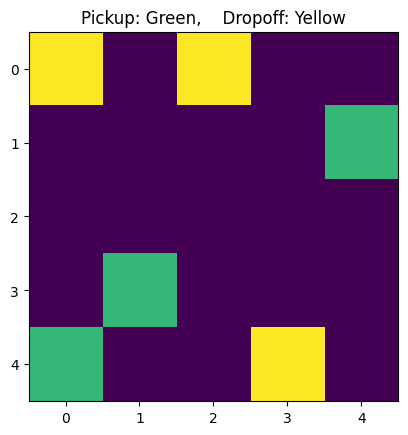

Episode done at step 358
Episode done at step 1


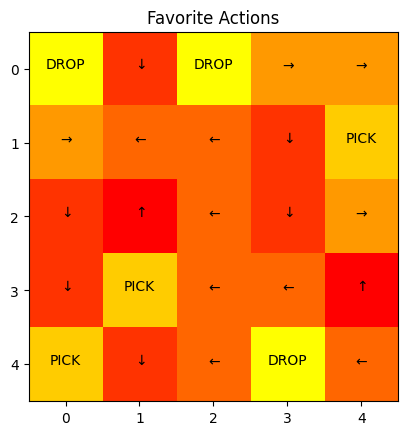

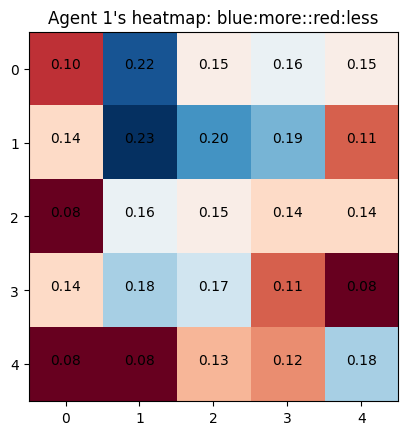

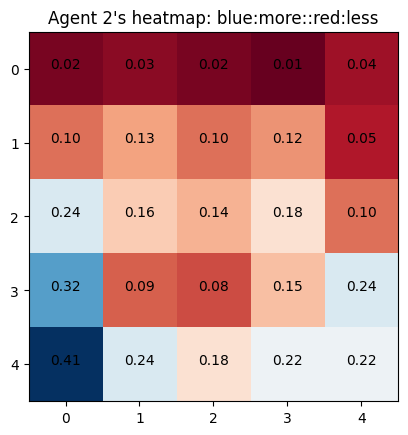

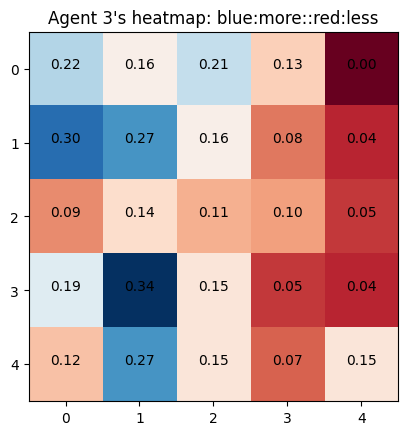

In [4]:
# Experiment 1A
# Continue PRandom policy

# New env so to start from the same point
# Set a fixed seed for reproducibility
np.random.seed(42)
env_1A = PDWorld_env(0.3, 3, 0.5, 0.2)
state = env_1A.reset()

visualize_world_sansAgents(env_1A.pickups, env_1A.dropoffs, env_1A.grid_size)

# Run PRandom for the first 500 steps (1A)
for step in range(500):
    # Randomly select actions for each agent
    state = env_1A.prandom()
    # Check if the episode is done
    if env_1A.is_done():
        print("Episode done at step", step + 1)
        break

# Show favorite actions after 500 random steps
# env_1A.show_favorite_actions()

# Now other 8500 RANDOM steps
for step in range(8500):
    # Randomly select actions for each agent
    
    state = env_1A.prandom()  # Initial total reward is 0
    
    # Check if the episode is done
    if env_1A.is_done():
        print("Episode done at step", step + 1)
        break


# env.show_reward_grid()
# env_1A.show_favorite_actions()
viz_MVP_grid(env_1A)
for i in range(3):
    env_1A.show_agent_grid(i)

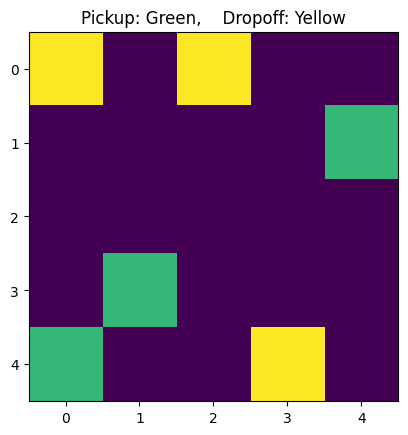

Episode done at step 126  in PGREEDY


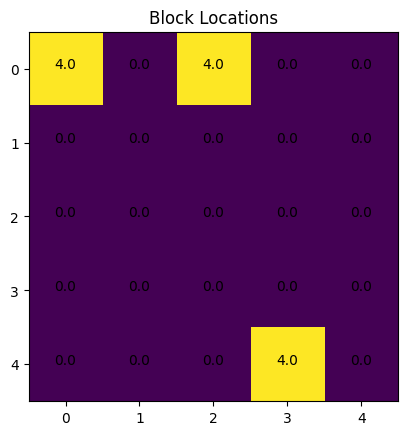

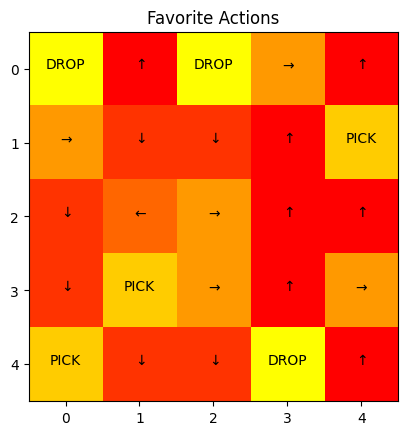

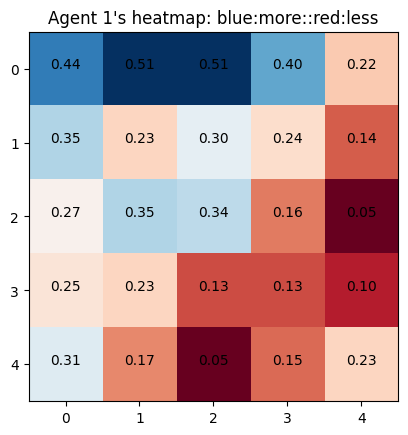

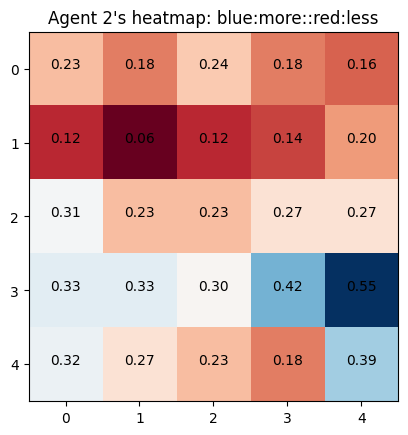

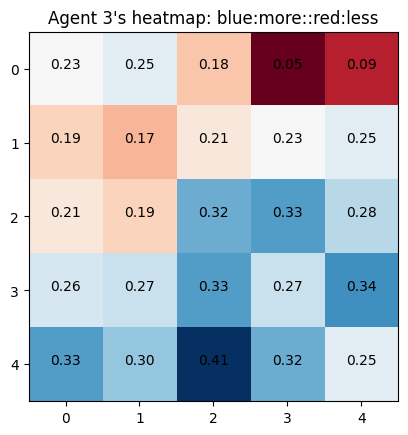

In [5]:
# Experiment 1B PGreedy policy

# Set a fixed seed for reproducibility
# np.random.seed(42)
np.random.seed(237)
env_1B = PDWorld_env(0.3, 3, 0.5, 0.2)
state = env_1B.reset()

actions = [0, 0, 0]

visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Run PRandom for the first 500 steps (1B)
for step in range(500):
    # Randomly select actions for each agent
    state = env_1B.prandom()

    if env_1B.is_done():
        print("Episode done at step", step + 1)
        env_1B.show_block_locations()
        break

for step in range(8500):

    state = env_1B.pgreedy()            
    
    if env_1B.is_done():
        print("Episode done at step", step + 1, " in PGREEDY")
        break
            


# env.show_reward_grid()
# env_1B.show_favorite_actions()
env_1B.show_block_locations()
viz_MVP_grid(env_1B)

for i in range(3):
    env_1B.show_agent_grid(i)


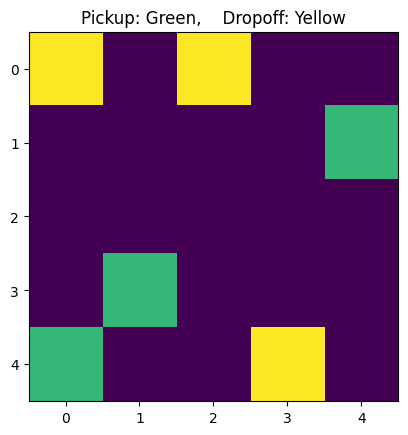

Episode done at step 431
Episode done at step 1 in PXPLOIT


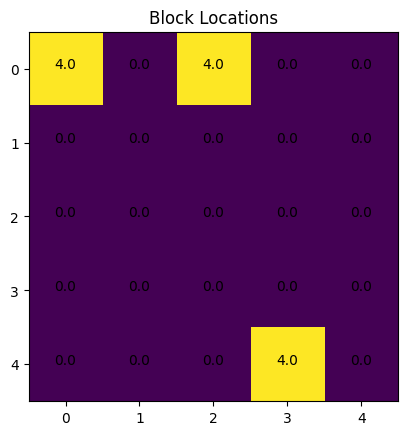

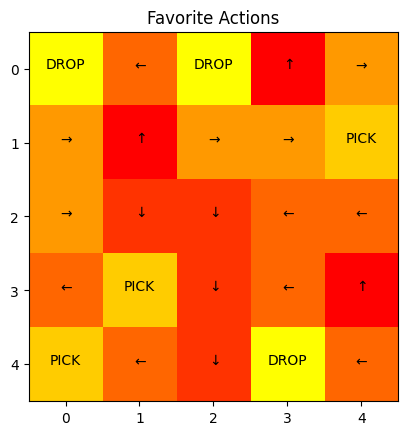

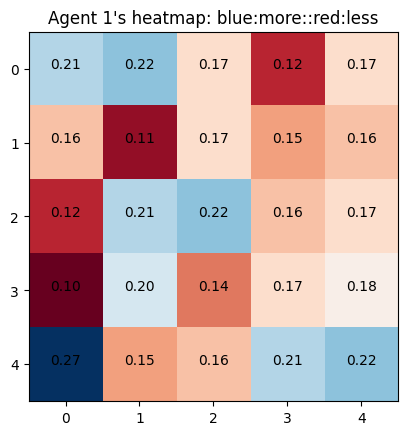

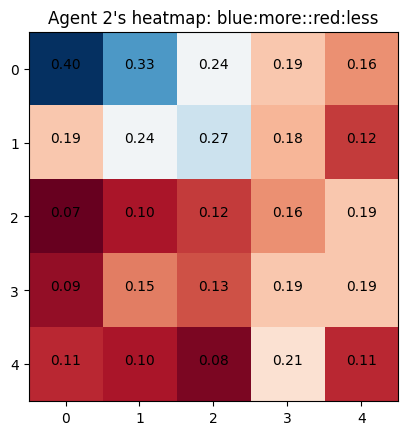

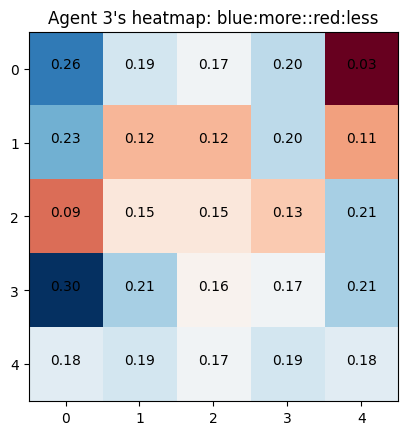

In [6]:
# Experiment 1C
# PExploit policy

env_1C = PDWorld_env(0.3, 3, 0.5, 0.2)
state = env_1C.reset()

# Set a fixed seed for reproducibility
np.random.seed(666)

visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Run PRandom for the first 500 steps (1B)
for step in range(500):
    # Randomly select actions for each agent
    state = env_1C.prandom()
    # Check if the episode is done
    if env_1C.is_done():
        print("Episode done at step", step + 1)
        break

# env_1C.show_favorite_actions()

for step in range(8500):

    state = env_1C.pxploit()
    
    if env_1C.is_done():
        print("Episode done at step", step + 1, "in PXPLOIT")
        break


# env_1C.show_favorite_actions()
env_1C.show_block_locations()
viz_MVP_grid(env_1C)
for i in range(3):
    env_1C.show_agent_grid(i)

## Experiment 2, SARSA Algorithm

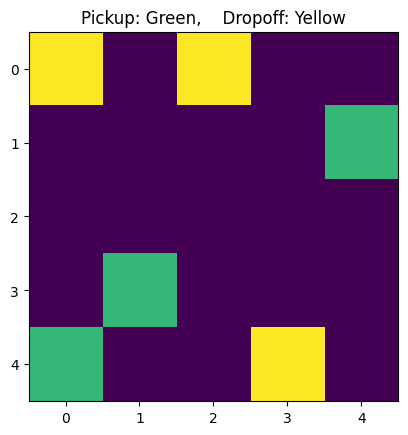

EX.2 episode done at step 346 in pSARSA


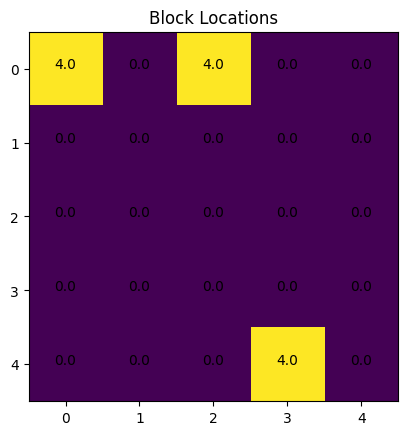

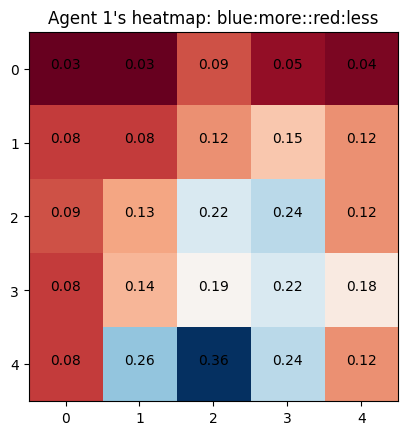

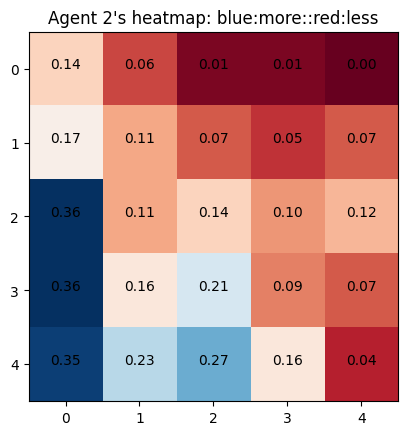

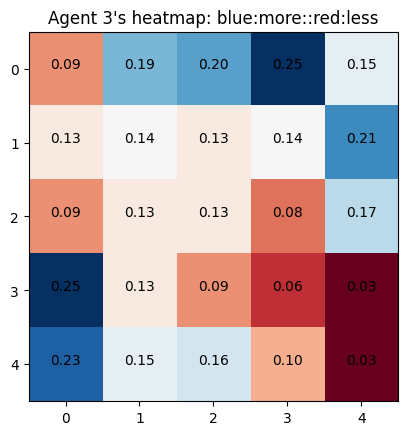

In [7]:
# Experiment 2
# PExploit policy w/ SARSA

env_2 = PDWorld_env(0.3, 3, 0.5, 0.2)
state = env_2.reset()

# Set a fixed seed for reproducibility
np.random.seed(666)

visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

for step in range(9000):

    state = env_2.pSARSA()
    
    if env_2.is_done():
        print("EX.2 episode done at step", step + 1, "in pSARSA")
        break


# env_2.show_favorite_actions()
# viz_MVP_grid(env_2)
env_2.show_block_locations()
for i in range(3):
    env_2.show_agent_grid(i)

#### Experiment 3 (Rerun experiment 1.C with alpha = 0.15)

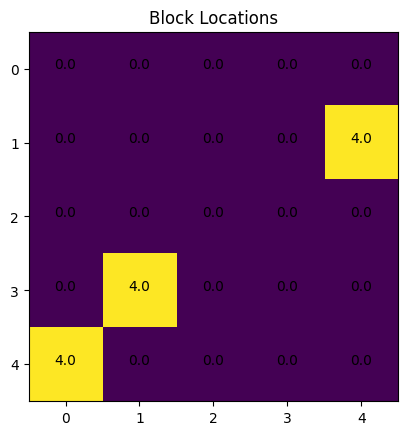

EX.3a episode done at step 20  with alpha=0.15


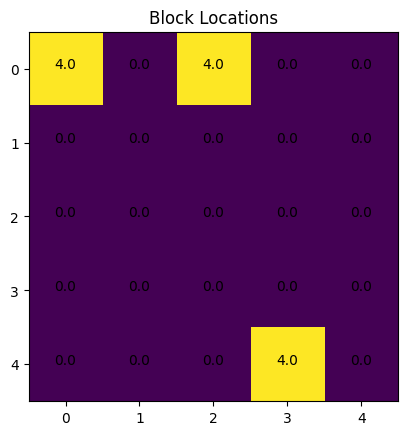

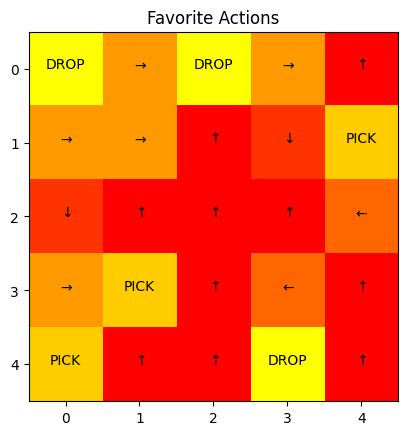

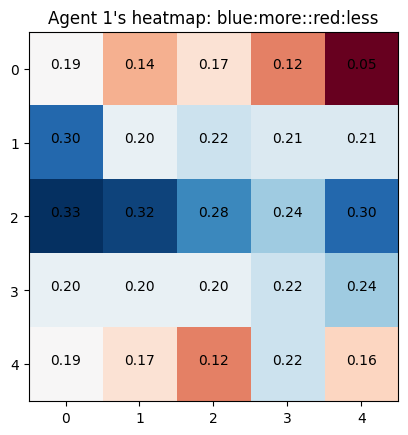

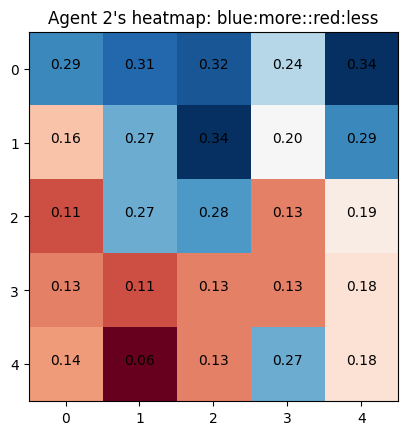

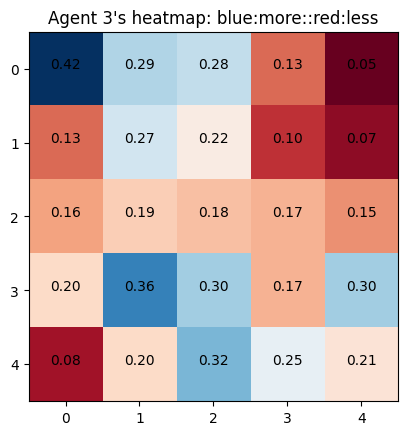

In [8]:
# Experiemtn 3a

# Initialize with alpha=0.15, ALSO GAMMA 0.9 BC IT WORKS BETTER
env_3_a = PDWorld_env(0.15, 3, 0.9, 0.2)

# Reset the environment to initialize the state
state = env_3_a.reset()
env_3_a.show_block_locations()
# Set a fixed seed for reproducibility
np.random.seed(777)

# Run PRandom for the first 500 steps
for step in range(500):
    # Randomly select actions for each agent
    state = env_3_a.prandom()

    if env_3_a.is_done():
        print("Episode done at step", step + 1)
        break

for step in range(8500):
    # Randomly select actions for each agent
    state = env_3_a.pxploit()

    if env_3_a.is_done():
        print("EX.3a episode done at step", step + 1, " with alpha=0.15")
        break

# env_3_a.show_favorite_actions()
env_3_a.show_block_locations()
viz_MVP_grid(env_3_a)
for i in range(3):
    env_3_a.show_agent_grid(i)


EX.3b episode done at step 61  with alpha=0.15


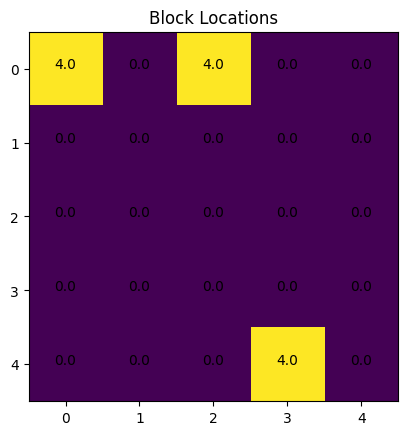

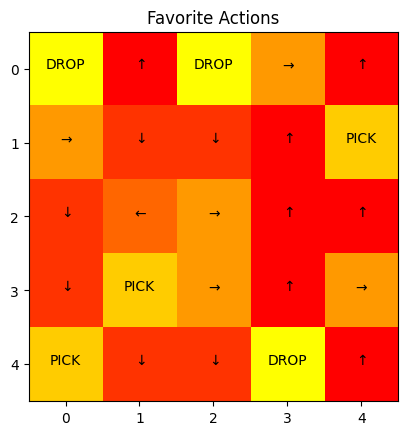

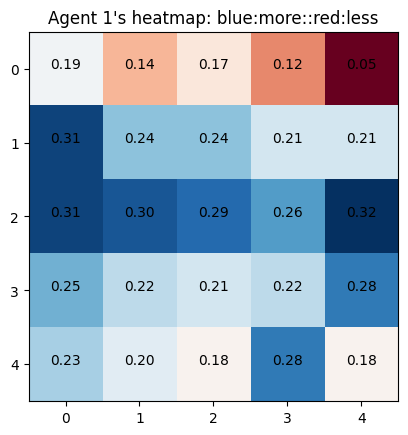

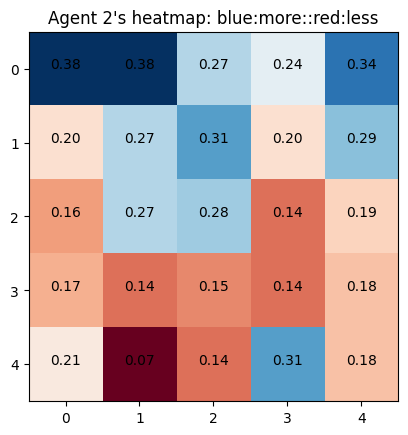

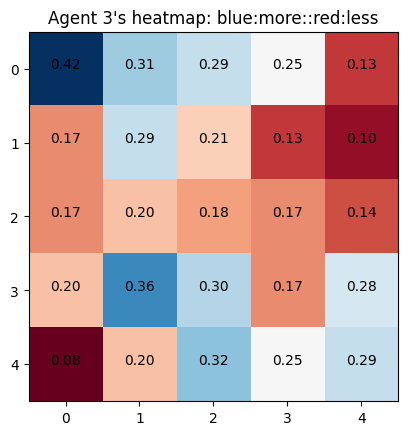

In [9]:
# Experiment 3b

# Initialize with alpha=0.45, ALSO GAMMA 0.9 BC IT WORKS BETTER
env_3_b = PDWorld_env(0.45, 3, 0.9, 0.2)

# Reset the environment to initialize the state
state = env_3_b.reset()

# Set a fixed seed for reproducibility
np.random.seed(777)

# Run PRandom for the first 500 steps
for step in range(500):
    # Randomly select actions for each agent
    state = env_3_b.prandom()

    if env_3_b.is_done():
        print("Episode done at step", step + 1)
        break

for step in range(8500):
    # Randomly select actions for each agent
    state = env_3_b.pxploit()

    if env_3_b.is_done():
        print("EX.3b episode done at step", step + 1, " with alpha=0.15")
        break

# env_3_b.show_favorite_actions()
env_3_b.show_block_locations()
viz_MVP_grid(env_1B)
for i in range(3):
    env_3_b.show_agent_grid(i)

# Experiment 4

In [10]:
env_4 = PDWorld_env(0.3, 3, 0.5, 0.2)
state = env_4.reset()

# Set a fixed seed for reproducibility
np.random.seed(77)

#visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Run PRandom for the first 500 steps 
for step in range(500):
    # Randomly select actions for each agent
    state = env_4.prandom()
    # Check if the episode is done
    if env_4.is_done():
        print("Episode done at step", step + 1)
        break




P exploit with old pickup spots: (4, 0), (3, 1), (1, 4)
Terminal State 1 reached at step 70
Terminal State 2 reached at step 594
Terminal State 3 reached at step 393


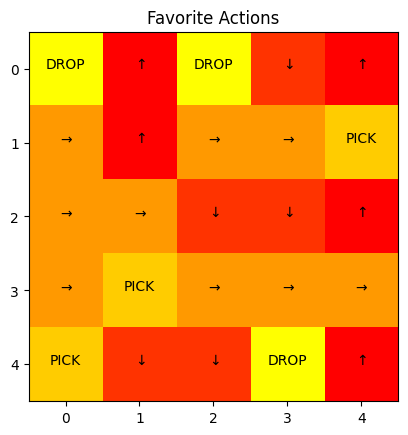

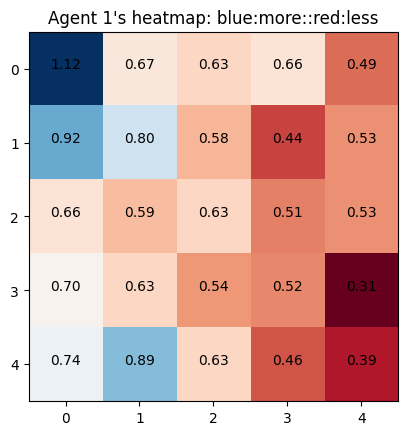

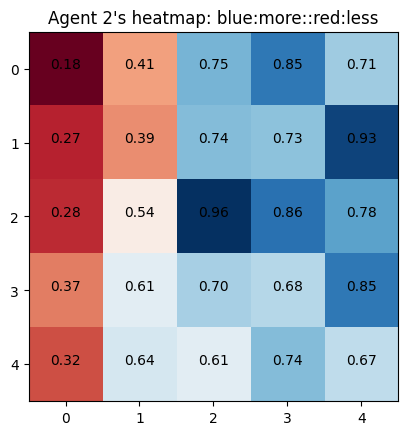

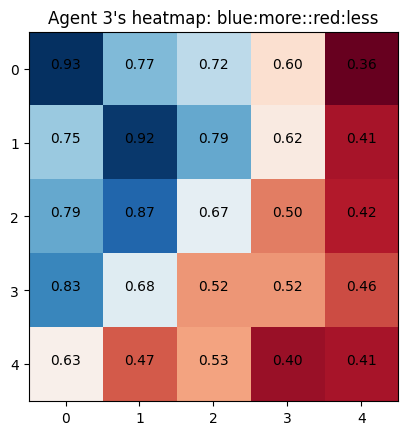

In [11]:
# run PEXPLOIT until terminal state reached 3 times
print("P exploit with old pickup spots: (4, 0), (3, 1), (1, 4)")
terminal_count = 0
step_count = 0

np.random.seed(77)
while(terminal_count < 3):

    state = env_4.pxploit()
    step_count += 1
    if env_4.is_done():
        terminal_count += 1
        print("Terminal State " + str(terminal_count) + " reached at step " + str(step_count))
        step_count = 0
        env_4.reset()


# env_4.show_favorite_actions()
viz_MVP_grid(env_4)
for i in range(3):
    env_4.show_agent_grid(i)

Below, the heatmaps are cumulative across all env_4 steps

P exploit with new pickup spots: (4,2), (3,3) (2,4)
Terminal State 1 reached at step 386
Terminal State 2 reached at step 543
Terminal State 3 reached at step 708


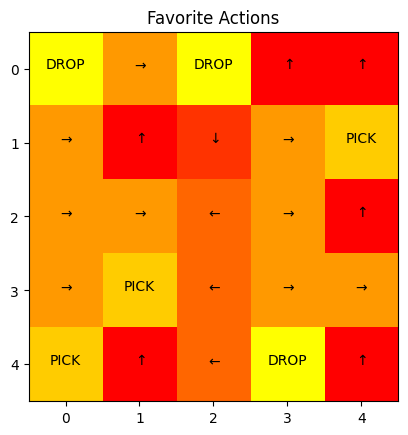

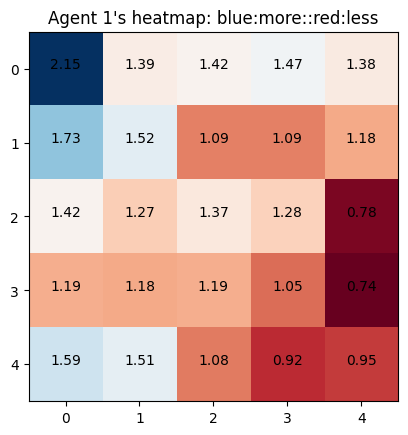

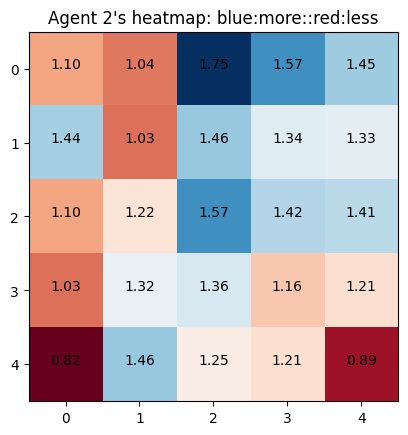

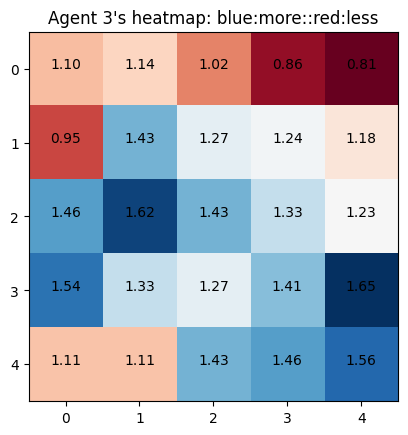

In [12]:
# run PEXPLOIT until terminal state reached 3 times
print("P exploit with new pickup spots: (4,2), (3,3) (2,4)")
env_4.change_pickup_spots()

terminal_count = 0
step_count = 0
while(terminal_count < 3):

    state = env_4.pxploit()
    step_count += 1
    if env_4.is_done():
        terminal_count += 1
        print("Terminal State " + str(terminal_count) + " reached at step " + str(step_count))
        step_count = 0
        env_4.reset()


# env_4.show_favorite_actions()
viz_MVP_grid(env_4)

for i in range(3):
    env_4.show_agent_grid(i)